# Deep Learning: Final Project

## Setup

In [1]:
!pip install torch torchvision numpy matplotlib pandas


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torchvision
import numpy as np
import torch
from torch.utils.data import DataLoader
import json
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import pandas as pd
import random

torch.manual_seed(42)
random.seed(42)

### Download pre-trained model

In [3]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

### Setup dataset

In [4]:
!unzip -n TestDataSet.zip

Archive:  TestDataSet.zip


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=mean_norms, std=std_norms) 
])

batch_size = 128
dataset_path = "./TestDataSet"
orig_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
orig_dataloader = DataLoader(orig_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
# Load label mapping
with open(dataset_path + '/labels_list.json', "r") as f:
    label_list = json.load(f)
class_idx = [int(label.split(': ')[0]) for label in label_list]
class_label = [label.split(': ')[1] for label in label_list]

# map imagenet index to labels
imagenet_class_mapping = {idx: label for idx, label in zip(class_idx, class_label)}

# map dataset target to imagenet target
label_to_imagenet = {target: idx for target, idx in enumerate(class_idx)}

In [7]:
def denormalize(image, mean_norms=mean_norms, std_norms=std_norms):
    """denormalize image tensor using mean/std"""
    mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(image.device)
    std = torch.tensor(std_norms).view(1, 3, 1, 1).to(image.device)
    return torch.clamp(image * std + mean, 0, 1)

## Task 1: Evaluate pre-trained model

In [8]:
def evaluate(model, dataloader, save_preds=False, col_name=None, filepath='pred.csv'):
    model = model.to(device)
    model.eval()

    top1_correct = 0
    top5_correct = 0
    total = 0
    preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # map targets from test dataset to imagenet predictions
            imagenet_labels = torch.tensor(
                [label_to_imagenet[int(l)] for l in labels], device=device
            )

            # get preds
            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)

            # Top-1 accuracy
            top1_correct += (top5_preds[:, 0] == imagenet_labels).sum().item()
            preds.extend(top5_preds[:, 0].cpu().numpy())

            # Top-5 accuracy
            for i in range(images.size(0)):
                if imagenet_labels[i].item() in top5_preds[i]:
                    top5_correct += 1

            total += images.size(0)

    # Compute accuracy
    top1_acc = top1_correct / total
    top5_acc = top5_correct / total

    # save predictions in csv if needed
    if save_preds:
        if not col_name:
            raise ValueError('Expected column name')
        if os.path.isfile(filepath):
            df = pd.read_csv(filepath)
            df[col_name] = preds
        else:
            df = pd.DataFrame({col_name: preds})
        df.to_csv(filepath, index=False)

    print(f"Top-1 Accuracy: {top1_acc * 100:.4f}%")
    print(f"Top-5 Accuracy: {top5_acc * 100:.4f}%")
    return preds

orig_preds = evaluate(pretrained_model, orig_dataloader, save_preds=True, col_name='orig')


Top-1 Accuracy: 76.0000%
Top-5 Accuracy: 94.2000%


## Task 2: Pixel-wise attacks

https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [9]:
fgsm_output_dir = "./AdversarialTestSet1"
os.makedirs(fgsm_output_dir, exist_ok=True)

In [10]:
adv_dataloader = torch.utils.data.DataLoader(orig_dataset, batch_size=1, shuffle=False)
epsilon = 0.02 / std_norms
epsilon_tensor = torch.tensor(epsilon).view(1, 3, 1, 1).to(device, dtype=torch.float32)

In [11]:
# FGSM attack
def fgsm_attack(image, label, model, epsilon_tensor):
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data

    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon_tensor * sign_data_grad
    min_vals = torch.tensor((0 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
    max_vals = torch.tensor((1 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)

    return torch.clamp(perturbed_image, min=min_vals, max=max_vals).to(dtype=torch.float32)

In [12]:
# Save images
from pathlib import Path

# Get original image file paths from the dataset
original_paths = [Path(orig_dataset.imgs[i][0]) for i in range(len(orig_dataset))]

# Attack loop
orig_images = []
fgsm_images = []

for i, (image, label) in enumerate(adv_dataloader):
    image, label = image.to(device), label.to(device)
    # map targets from test dataset to imagenet predictions
    imagenet_label = torch.tensor([label_to_imagenet[int(label.item())]], device=device)
    fgsm_image = fgsm_attack(image.clone(), imagenet_label, pretrained_model, epsilon_tensor)
    orig_images.append(image.squeeze(0).cpu())
    fgsm_images.append(fgsm_image.squeeze(0).cpu())

    # Determine relative path inside dataset
    orig_path = original_paths[i]
    rel_path = orig_path.relative_to(orig_dataset.root)
    save_path = Path(fgsm_output_dir) / rel_path

    # Make directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert and save
    img_denorm = denormalize(fgsm_image).squeeze(0)
    pil_img = TF.to_pil_image(img_denorm)
    pil_img.save(save_path)


### Get FGSM accuracy drop

In [13]:
fgsm_dataset = torchvision.datasets.ImageFolder(root=fgsm_output_dir, transform=plain_transforms)
fgsm_dataloader = DataLoader(fgsm_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
fgsm_preds = evaluate(pretrained_model, fgsm_dataloader, save_preds=True, col_name='fgsm')

Top-1 Accuracy: 6.0000%
Top-5 Accuracy: 31.2000%


### Verify L_inf

In [14]:
# Report L_inf statistics
def get_max_linf(orig_images, adv_images):
    assert len(orig_dataset) == len(orig_images)

    max_diff = 0
    for orig_image, adv_image in zip(orig_images, adv_images):
        denorm_orig_image = denormalize(orig_image)
        denorm_adv_image = denormalize(adv_image)
        diff = torch.abs(denorm_orig_image - denorm_adv_image)
        max_diff = max(max_diff, diff.max().item())
    print(rf"Max L_inf difference: {max_diff:.5f}")

get_max_linf(orig_images, fgsm_images)

Max L_inf difference: 0.02000


### Get Successful Attack Samples

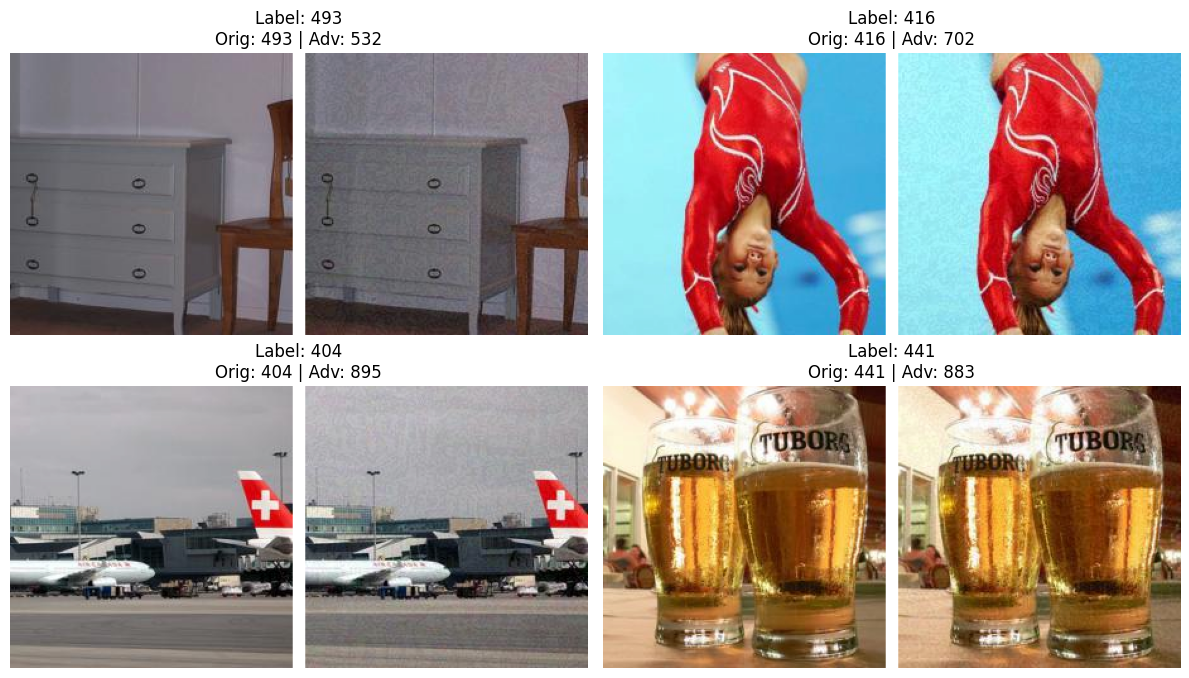

In [15]:
def show_successful_attacks_grid(indices, model, orig_dataset, adv_dataset):
    model.eval()
    rows, cols = 2, 2  # 2x2 grid
    fig, axs = plt.subplots(rows, cols, figsize=(12, 7))
    axs = axs.flatten()

    for i, idx in enumerate(indices):
        orig_img, label1 = orig_dataset[idx]
        adv_img, _ = adv_dataset[idx]
        label = label1

        with torch.no_grad():
            orig_pred = model(orig_img.unsqueeze(0).to(device)).argmax(dim=1).item()
            adv_pred = model(adv_img.unsqueeze(0).to(device)).argmax(dim=1).item()

        orig_vis = denormalize(orig_img.unsqueeze(0)).squeeze(0).cpu()
        adv_vis = denormalize(adv_img.unsqueeze(0)).squeeze(0).cpu()
        
        # Create a white spacer
        spacer_width = 10
        _, height, _ = orig_vis.shape
        spacer = torch.ones(3, height, spacer_width)  # white space

        # Combine original and adversarial images horizontally
        combined = torch.cat([orig_vis, spacer, adv_vis], dim=2)  # concatenate along width
        axs[i].imshow(TF.to_pil_image(combined))
        axs[i].set_title(f"Label: {label_to_imagenet[label]}\nOrig: {orig_pred} | Adv: {adv_pred}")
        axs[i].axis('off')

    # Hide any unused subplots
    for j in range(len(indices), rows * cols):
        axs[j].axis('off')

    plt.tight_layout()
    plt.savefig('fgsm.pdf')
    plt.show()

successful_attacks = []
df = pd.read_csv('pred.csv')

for idx, row in df.iterrows():
    img, label = orig_dataset[idx]
    if label_to_imagenet[label] == row['orig'] and row['orig'] != row['fgsm']:
        successful_attacks.append(idx)

# Show 4 random successful attacks
selected = random.sample(successful_attacks, min(4, len(successful_attacks)))
show_successful_attacks_grid(selected, pretrained_model, orig_dataset, fgsm_dataset)


## Task 3: Improved Attacks

### Projected Gradient Descent

In [16]:
def pgd_attack(model, images, labels, epsilon, alpha, num_iter, mean_norms=mean_norms, std_norms=std_norms):
    """
    PGD attack under L∞ norm.

    Args:
        model: pretrained model
        images: normalized input images (B, C, H, W)
        labels: correct labels (mapped to ImageNet indices)
        epsilon: max perturbation (same shape as image or broadcastable)
        alpha: step size (same shape as epsilon)
        num_iter: number of attack steps
        mean_norms, std_norms: normalization used in preprocessing

    Returns:
        perturbed images (still normalized)
    """
    ori_images = images.clone().detach()
    perturbed = images.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        outputs = model(perturbed)
        model.zero_grad()
        loss = F.cross_entropy(outputs, labels)
        loss.backward()

        # Gradient sign
        grad_sign = perturbed.grad.data.sign()

        # Apply perturbation and clip to epsilon
        perturbed = perturbed + alpha * grad_sign
        delta = torch.clamp(perturbed - ori_images, min=-epsilon, max=epsilon)

        min_vals = torch.tensor((0 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
        max_vals = torch.tensor((1 - mean_norms) / std_norms, dtype=torch.float32, device=image.device).view(1, 3, 1, 1)
        perturbed = torch.clamp(ori_images + delta, min=min_vals, max=max_vals).to(torch.float32)
        perturbed = perturbed.detach().requires_grad_(True)

    return perturbed


In [21]:
pgd_output_dir = "./AdversarialTestSet2"

alpha = epsilon / 10
alpha_tensor = torch.tensor(alpha).view(1, 3, 1, 1).to(device, dtype=torch.float32)

pgd_images = []

pretrained_model.eval()
for i, (image, label) in enumerate(adv_dataloader):
    image, label = image.to(device), label.to(device)
    imagenet_label = torch.tensor([label_to_imagenet[int(label.item())]], device=device)
    pgd_img = pgd_attack(pretrained_model, image, imagenet_label, epsilon_tensor, alpha_tensor, num_iter=20)
    pgd_images.append(pgd_img.cpu())

# Get original image file paths from the dataset
original_paths = [Path(orig_dataset.imgs[i][0]) for i in range(len(orig_dataset))]

# Save loop
for i, (img, orig_path) in enumerate(zip(pgd_images, original_paths)):
    # Determine relative path inside dataset
    rel_path = orig_path.relative_to(orig_dataset.root)
    save_path = Path(pgd_output_dir) / rel_path

    # Make directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert and save
    img_denorm = denormalize(img).squeeze(0)
    pil_img = TF.to_pil_image(img_denorm)
    pil_img.save(save_path)


In [22]:
pgd_dataset = torchvision.datasets.ImageFolder(root=pgd_output_dir, transform=plain_transforms)
pgd_dataloader = DataLoader(pgd_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
pgd_preds = evaluate(pretrained_model, pgd_dataloader, save_preds=True, col_name='pgd')

Top-1 Accuracy: 0.2000%
Top-5 Accuracy: 29.6000%


In [19]:
get_max_linf(orig_images, pgd_images)

Max L_inf difference: 0.02000


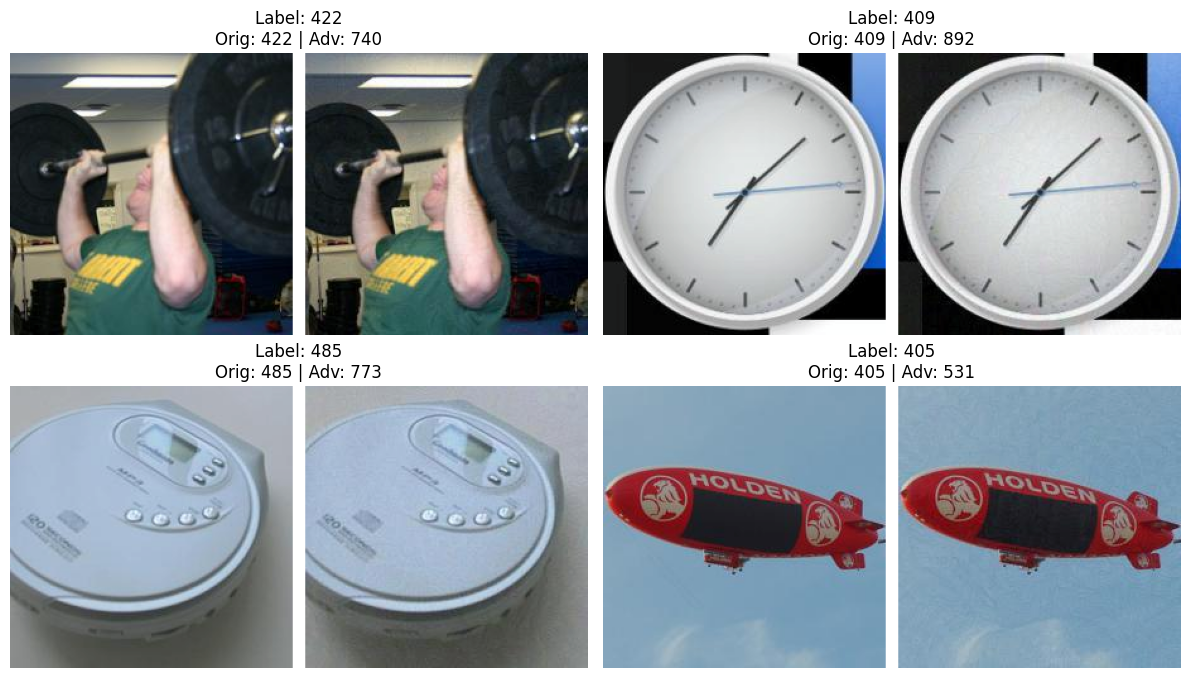

In [20]:
successful_attacks = []
df = pd.read_csv('pred.csv')

for idx, row in df.iterrows():
    img, label = orig_dataset[idx]
    if label_to_imagenet[label] == row['orig'] and \
       row['orig'] == row['fgsm'] and \
       row['fgsm'] != row['pgd']:
        successful_attacks.append(idx)

# Show 5 random successful attacks
selected = random.sample(successful_attacks, min(4, len(successful_attacks)))
show_successful_attacks_grid(selected, pretrained_model, orig_dataset, pgd_dataset)

### Auto-PGD

In [23]:
def apgd_attack(model, image, label, epsilon_tensor, alpha_tensor, num_iter,
                         mean_norms=mean_norms, std_norms=std_norms,
                         patience=5, step_drop_factor=0.5, min_alpha=1e-5):
    """
    APGD with adaptive step size under L∞ norm for full image.

    Args:
        model: pretrained model
        image: normalized input image (B, C, H, W)
        label: true label
        epsilon_tensor: max perturbation
        alpha_tensor: step size (broadcastable tensor)
        num_iter: max steps
        mean_norms, std_norms: normalization
        patience: how many steps to wait before reducing step size
        step_drop_factor: factor to reduce step size
        min_alpha: stop if step size goes below this

    Returns:
        Perturbed image
    """
    device = image.device
    ori_image = image.clone().detach()

    mean = torch.tensor(mean_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
    std = torch.tensor(std_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
    min_vals = ((0 - mean) / std)
    max_vals = ((1 - mean) / std)

    # Initialization
    perturbed = ori_image + torch.empty_like(image).uniform_(-1.0, 1.0) * epsilon_tensor
    perturbed = torch.clamp(perturbed, min_vals, max_vals).detach().requires_grad_(True)

    best_adv = perturbed.clone().detach()
    best_loss = torch.full((image.size(0),), -float('inf'), device=device)

    alpha = alpha_tensor.clone()
    stagnant_steps = 0
    prev_avg_loss = None

    for i in range(num_iter):
        output = model(perturbed)
        loss = F.cross_entropy(output, label, reduction='none')
        grad = torch.autograd.grad(loss.sum(), perturbed)[0]

        perturbed = perturbed + alpha * grad.sign()
        delta = torch.clamp(perturbed - ori_image, -epsilon_tensor, epsilon_tensor)
        perturbed = torch.clamp(ori_image + delta, min_vals, max_vals).detach().requires_grad_(True)

        with torch.no_grad():
            output = model(perturbed)
            current_loss = F.cross_entropy(output, label, reduction='none')
            mask = current_loss > best_loss
            best_loss[mask] = current_loss[mask]
            best_adv[mask] = perturbed[mask]

            avg_loss = current_loss.mean().item()
            if prev_avg_loss is not None and abs(avg_loss - prev_avg_loss) < 1e-4:
                stagnant_steps += 1
            else:
                stagnant_steps = 0
            prev_avg_loss = avg_loss

        # Adapt step size
        if stagnant_steps >= patience:
            alpha = alpha * step_drop_factor
            stagnant_steps = 0
            if alpha.min().item() < min_alpha:
                break  # Exit early if step size is too small

    return best_adv.detach()


In [24]:
apgd_output_dir = "./AdversarialTestSet3"

apgd_images = []

pretrained_model.eval()
for i, (image, label) in enumerate(adv_dataloader):
    image, label = image.to(device), label.to(device)
    imagenet_label = torch.tensor([label_to_imagenet[int(label.item())]], device=device)
    apgd_img = apgd_attack(pretrained_model, image, imagenet_label, epsilon_tensor, alpha_tensor, 30)
    apgd_images.append(apgd_img.cpu())

# Save loop
for i, (img, orig_path) in enumerate(zip(apgd_images, original_paths)):
    # Determine relative path inside dataset
    rel_path = orig_path.relative_to(orig_dataset.root)
    save_path = Path(apgd_output_dir) / rel_path

    # Make directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert and save
    img_denorm = denormalize(img).squeeze(0)
    pil_img = TF.to_pil_image(img_denorm)
    pil_img.save(save_path)


In [25]:
apgd_dataset = torchvision.datasets.ImageFolder(root=apgd_output_dir, transform=plain_transforms)
apgd_dataloader = DataLoader(apgd_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
apgd_preds = evaluate(pretrained_model, apgd_dataloader, save_preds=True, col_name='apgd')

Top-1 Accuracy: 4.2000%
Top-5 Accuracy: 48.6000%


In [24]:
get_max_linf(orig_images, apgd_images)

Max L_inf difference: 0.02000


## Task 4: Patch Attacks


In [25]:
def patch_pgd_attack(model, image, label, epsilon, alpha, num_iter,
                     mean_norms=mean_norms, std_norms=std_norms, patch_size=32):
    """
    PGD attack applied only to a patch of each image.

    Args:
        model: pretrained model
        images: normalized input images (B, C, H, W)
        labels: correct labels
        epsilon, alpha: scalar or broadcastable tensors
        num_iter: number of PGD steps
        mean_norms, std_norms: normalization used
        patch_size: square patch size to perturb

    Returns:
        Perturbed images (still normalized)
    """

    B, C, H, W = image.shape

    ori_image = image.clone().detach()
    perturbed = ori_image.clone().detach().requires_grad_(True)

    # Create patch mask
    patch_masks = torch.zeros_like(ori_image)
    top = (H - patch_size) // 2
    left = (W - patch_size) // 2
    patch_masks[:, :, top:top+patch_size, left:left+patch_size] = 1.0


    for _ in range(num_iter):
        output = model(perturbed)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()

        grad_sign = perturbed.grad.data.sign()

        # Restrict update to patch only
        perturb_update = alpha * grad_sign * patch_masks
        perturbed = perturbed + perturb_update

        # Restrict delta and clip
        delta = torch.clamp(perturbed - ori_image, min=-epsilon, max=epsilon)
        delta = delta * patch_masks  # Only retain deltas in the patch

        min_vals = torch.tensor((0 - mean_norms) / std_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
        max_vals = torch.tensor((1 - mean_norms) / std_norms, dtype=torch.float32, device=device).view(1, 3, 1, 1)
        perturbed = torch.clamp(ori_image + delta, min=min_vals, max=max_vals).detach().requires_grad_(True)

    return perturbed

In [26]:
patch_pgd_output_dir = "./AdversarialTestSet4"

patch_pgd_images = []

patch_epsilon = 0.3 / std_norms
patch_epsilon_tensor = torch.tensor(patch_epsilon, dtype=torch.float32, device=device).view(1, 3, 1, 1)
patch_alpha = patch_epsilon / 10
patch_alpha_tensor = torch.tensor(patch_alpha).view(1, 3, 1, 1).to(device, dtype=torch.float32)

pretrained_model.eval()
for i, (image, label) in enumerate(adv_dataloader):
    image, label = image.to(device), label.to(device)
    imagenet_label = torch.tensor([label_to_imagenet[int(label.item())]], device=device)
    patch_pgd_img = patch_pgd_attack(pretrained_model, image, imagenet_label, patch_epsilon_tensor, patch_alpha_tensor, 200)
    patch_pgd_images.append(patch_pgd_img.cpu())

# Save loop
for i, (img, orig_path) in enumerate(zip(patch_pgd_images, original_paths)):
    # Determine relative path inside dataset
    rel_path = orig_path.relative_to(orig_dataset.root)
    save_path = Path(patch_pgd_output_dir) / rel_path

    # Make directory if needed
    save_path.parent.mkdir(parents=True, exist_ok=True)

    # Convert and save
    img_denorm = denormalize(img).squeeze(0)
    pil_img = TF.to_pil_image(img_denorm)
    pil_img.save(save_path)


KeyboardInterrupt: 

In [ ]:
patch_pgd_dataset = torchvision.datasets.ImageFolder(root=patch_pgd_output_dir, transform=plain_transforms)
patch_pgd_dataloader = DataLoader(patch_pgd_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
patch_pgd_preds = evaluate(pretrained_model, patch_pgd_dataloader, save_preds=True, col_name='patch_pgd')

Top-1 Accuracy: 8.20%
Top-5 Accuracy: 49.20%


## Task 5: Transferring Attacks

In [ ]:
new_model = torchvision.models.efficientnet_v2_s(weights='IMAGENET1K_V1')

dataloaders = {
    'original': orig_dataloader,
    'fgsm': fgsm_dataloader,
    'pgd': pgd_dataloader,
    'apgd': apgd_dataloader,
    'patch_pgd': patch_pgd_dataloader
}

for name, dataloader in dataloaders.items():
    print(f'Evaluating {name} dataset')
    evaluate(new_model, dataloader)
    print()


Evaluating original dataset
Top-1 Accuracy: 85.20%
Top-5 Accuracy: 98.40%

Evaluating fgsm dataset
Top-1 Accuracy: 69.60%
Top-5 Accuracy: 91.80%

Evaluating pgd dataset
Top-1 Accuracy: 77.40%
Top-5 Accuracy: 95.00%

Evaluating apgd dataset
Top-1 Accuracy: 78.80%
Top-5 Accuracy: 95.80%

Evaluating patch_pgd dataset
Top-1 Accuracy: 81.20%
Top-5 Accuracy: 97.00%

